引入依赖

In [1]:
import torch
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

数据预处理

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

数据集准备

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True,
                               download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False,
                              download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


展示数据集

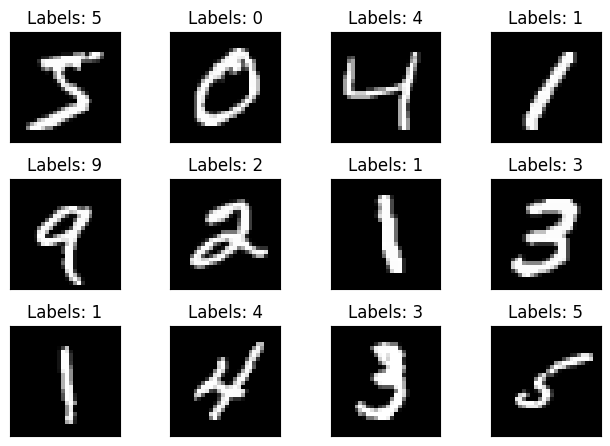

In [4]:
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

定义CNN模型

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),#卷积
            torch.nn.ReLU(),#ReLU激活
            torch.nn.MaxPool2d(kernel_size=2),#最大池化
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),#线性化
            torch.nn.Linear(50, 10),
        )
    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 卷积+激活+池化
        x = self.conv2(x)  # 卷积+激活+池化
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

实例化模型

In [6]:
model = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

训练&测试

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.289711
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.804666
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.611075
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.456656
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.385882
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.272361
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.268645
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.224828
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.243398
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.250209
Accuracy on test set: 93.17%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.109633
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.099577
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.187608
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.140319
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.138366
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.098386
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.216456
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.110269
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.129697
Train Epoch: 2 [57600/60000 (96%)

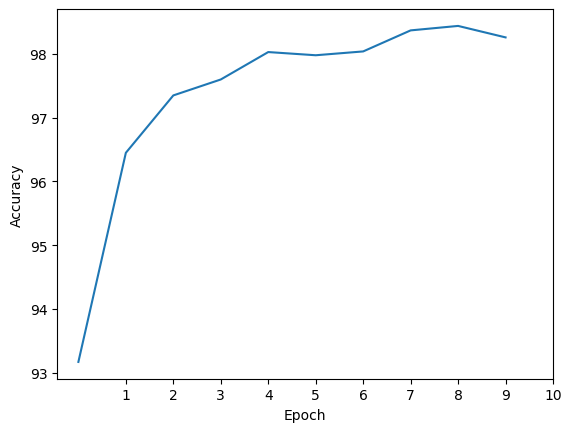

In [7]:
epochs = 10
acc_test_list = []  # 用于存储每个 epoch 的测试准确率

def train(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 在测试过程中禁用梯度计算
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    acc_test_list.append(accuracy)  # 在每个 epoch 结束后添加准确率
    print(f'Accuracy on test set: {accuracy}%')

for epoch in range(1, epochs + 1):
    train(epoch)
    test()

plt.plot(acc_test_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, epochs + 1))
plt.show()